# 0. Description
This notebook is part of Pose Classification Application for children ADHD Detecting.

Following contents will include
    - Training code with Pytorch
    - Training loss and validation loss matplot
    - Early stopping to prevent overfitting
    - visualizing else

# 1. Setting

In [19]:
!pip install torch torchvision tqdm matplotlib mediapipe pandas

In [20]:
# Libraries
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import math
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('USING pyTorch Version:', torch.__version__, ' Device:', DEVICE)

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

USING pyTorch Version: 1.10.1+cu102  Device: cpu


In [21]:
# Mediapipe function setting

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results


def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## 얘는 한 프레임에 pose, face, lh, rh 가 한 행에 다 flatten 되어있는 형태로 만들어짐.

# 2. Data Loading and Preprocessing

In [22]:
# Setup for X, y

# Actions that we try to detect
actions = np.array(['sitting', 'standing','walking','running','kicking','punching'])

# Data path
DATA_PATH = os.path.join('../video_training') 

# y setting
label_map = {label:num for num, label in enumerate(actions)}

# X and y setting
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(1, 30):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# ??? 왜 해야하는지 모르겠다. 연산에서 사이즈 안맞아서 이렇게 했다.
X = X.swapaxes(1,2)
print("X shape is: {} \ny shape is: {}".format(X.shape, y.shape))

X shape is: (180, 1662, 29) 
y shape is: (180, 6)


In [23]:
# train test split

## x is (180, 1662, 29), 180 = 30 folders for 6 actions.
## last 3 folders will become test data.

train_dataset_x = X[0:27]
train_dataset_y = y[0:27]

test_dataset_x = X[27:30]
test_dataset_y = y[27:30]

for i in range(2,7):
    train_dataset_x = np.concatenate((train_dataset_x, X[(i-1)*30:i*30-3]), axis = 0)
    train_dataset_y = np.concatenate((train_dataset_y, y[(i-1)*30:i*30-3]), axis = 0)
   
    test_dataset_x = np.concatenate((test_dataset_x, X[i*30-3:i*30]), axis = 0)
    test_dataset_y = np.concatenate((test_dataset_y, y[i*30-3:i*30]), axis = 0)

print("train X shape: {} \ttest X shape: {}".format(train_dataset_x.shape, test_dataset_x.shape))
print("train y shape: {} \ttest y shape: {}".format(train_dataset_y.shape, test_dataset_y.shape))

train X shape: (162, 1662, 29) 	test X shape: (18, 1662, 29)
train y shape: (162, 6) 	test y shape: (18, 6)


In [24]:

from torch.utils.data import DataLoader
input_size = 29
batch_size = 27
num_layers = 1
hidden_size = 64
output_size = actions.shape[0]

# 아래를 왜 하는지 알아보자 추후에.
train_dataset_x = torch.tensor(train_dataset_x, dtype=torch.float32)
train_dataset_y = torch.tensor(train_dataset_y, dtype=torch.long)

test_dataset_x = torch.tensor(test_dataset_x, dtype=torch.float32)
test_dataset_y = torch.tensor(test_dataset_y, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(train_dataset_x, train_dataset_y)
test_dataset = torch.utils.data.TensorDataset(test_dataset_x, test_dataset_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.device = DEVICE
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, output_size), 
                                nn.Sigmoid())
        # LSTM = input_size, hidden_size, num_layers, bias, batch_first, dropout, bidirectional
        #self.LSTM_1 = nn.LSTM(29, 64, 1)
        #self.fc = nn.Linear(64, actions.shape[0])
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size)# 초기 hidden state 설정하기.
            # h0.shape # torch.Size([num_layer, batch_size, hidden_size])
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
        #print("out's shape: {}".format(out.shape))
        #out = out.reshape(out.shape[0], -1) # many to many 전략
        
        out = self.fc(out)
        return out

model = BaseModel()

# 3. DL model setting and training

In [7]:
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
min_loss = np.Inf

num_epochs = 100

loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_dataloader)

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    n_batches = 0
    
    for data in tqdm(train_dataloader):
        #print("epoch: {}".format(epoch))
        seq, target = data # 배치 데이터.
        #print("seq type: {} \tseq shape:")
        #print('seq shape: {} \ttarget shape: {}'.format(seq.shape, target.shape))
            # seq shape: torch.Size([10, 29, 1662]) 
            # target shape: torch.Size([10, 6])
        
        optimizer.zero_grad() # 
        out = model(seq)   # 모델에 넣고,
        
        loss = criterion(out, target) # output 가지고 loss 구하고,        
        loss.backward() # loss가 최소가 되게하는
        
        optimizer.step() # 가중치 업데이트 해주고,
        running_loss += loss.item() # 한 배치의 loss 더해주고,
        
        n_batches +=1
        
    running_loss /= n_batches
    loss_graph.append(running_loss)
    
    if(epoch % 10 == 0):
        print('[epoch: %d] loss: %.4f'%(epoch, running_loss))

100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[epoch: 0] loss: 7.4088


 33%|███▎      | 2/6 [00:00<00:01,  2.78it/s]


KeyboardInterrupt: 

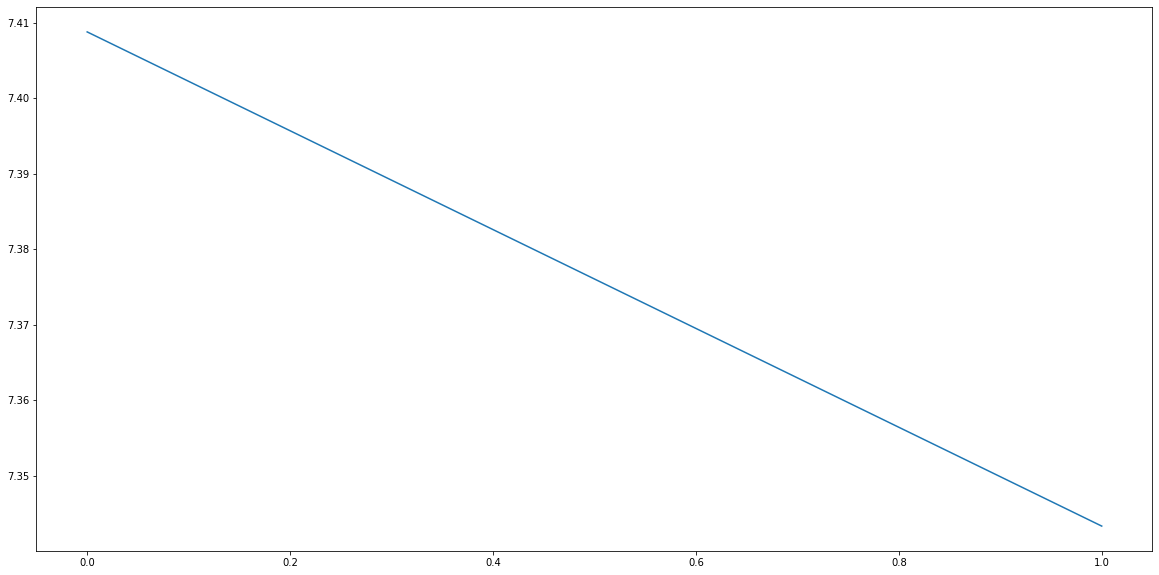

In [25]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

# 4. Model save and Test

In [26]:
# model save
from time import time, gmtime, localtime

_time = time()
_time = gmtime(_time)

_h5_file_name = '../model/RNN_ver' + str(_time.tm_mon) + str(_time.tm_mday) + '.pt'
_h5_file_name

torch.save(model.state_dict(), _h5_file_name)

In [27]:
# model load

model = BaseModel()
model.load_state_dict(torch.load('../model/RNN_ver928.pt'))

<All keys matched successfully>

In [28]:
# predict function

## set the Test function

def predict_oneframe(image): # for just one frame prediction
    '''
    criterion = nn.CrossEntropyLoss()
    model = model.to(DEVICE)
    '''
    #model.eval()

    correct = 0
    predict = 0
    cost = 0
    n_batches = 0
    loss_evaluate = 0
    
    model.eval()
    
    with torch.no_grad():
        #image = image.to(DEVICE)
        
        y_hat = model(image)
        y_hat.argmax()
        
    return y_hat

In [11]:
'''_max_count = np.zeros(6)

for i in range(0, 1662):
    _max_idx = np.argmax(res[i])
    #print("max idx : ", type(_max_idx))
    _max_count[_max_idx] += 1

    
print("result: ", _max_count)
'''

'_max_count = np.zeros(6)\n\nfor i in range(0, 1662):\n    _max_idx = np.argmax(res[i])\n    #print("max idx : ", type(_max_idx))\n    _max_count[_max_idx] += 1\n\n    \nprint("result: ", _max_count)\n'

In [29]:
# this is for test - predict_oneframe()
import pandas as pd
from time import time, gmtime, localtime

def _get_time():
    _ct = gmtime(time())
    hour = _ct.tm_hour+9
    minute = _ct.tm_min
    
    return _ct, hour, minute

def action_record(bh, bm, ct, action, c):
    _t = ct
    
    _year = _t.tm_year
    _month = _t.tm_mon
    _day = _t.tm_mday
    _hour = _t.tm_hour+9
    _min = _t.tm_min
    _action = actions[action]
    _du_h = _hour - bh
    _du_m = _min - bm
    
    _du = _du_h*60 + _du_m
    _co = action_count[action]
    
    action_time_log.loc[c-1] = [_year, _month, _day, _hour, _min, _action, 0, _co]
    
    if c != 1:
        action_time_log.loc[c-2,'Duration'] = _du
    return _hour, _min

# action count, time logging
action_count = np.zeros(actions.shape[0])
action_time_log = pd.DataFrame(columns=['Year', 'Month', 'Day', 'Hour', 'Minute','Action','Duration','Count'])


sequence = []
sentence = []
predictions = []
threshold = 0.5
co = 0
_new_h = 0
_new_m = 0
_bef_h = 0
_bef_m = 0

cap = cv2.VideoCapture('../input2.avi')
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-29:]
        
        if len(sequence) == 29:
            sequence_test = np.expand_dims(sequence, axis=0).swapaxes(1,2)
            
            sequence_test = torch.tensor(sequence_test, dtype=torch.float32)
            #print("30fps, np expand is: ", np.expand_dims(sequence, axis=0))
            #print("shape is: {}".format(np.expand_dims(sequence, axis=0).shape))
                # np.expand_dims(sequence, axis=0) (1, 30, 1662)
                # ex x shape was:                  (180, 30, 1662)
                # train X shape:                   (162, 1662, 29)
                # sequece_test shape:              (1, 1662, 29)
            #print(type(sequence_test))
                # sequence_test type is numpy.ndarray
            res = predict_oneframe(sequence_test)[0]
                # predict_oneframe shape:          torch.Size([1, 1662, 6])
            
            #print('res: {}'.format(res.shape))
                # res: torch.Size([1662, 6])
            #print('res: {}'.format(predict_oneframe(sequence_test).shape))
                # predict_oneframe(sequence_test) shape: torch.Size([1, 1662, 6])
            
            #print('res shape: {} \targmax: {}'.format(res.shape, np.argmax(res[1])))
                # res shape:                       torch.Size([1662, 6]) 
                # np.argmax(res):                  8
                # 결과 action은 res[1] 에 저장되어있다
                
                
            #print(actions[np.argmax(res[1660])])
            predictions.append(np.argmax(res[1660]))
            
        
        #3. Visualize and count, logging logic
            if np.unique(predictions[-10:])[0]==np.argmax(res[1600]): # 최근 10개의 action이 현재 분류된 action과 같으면
            
                if res[1600][np.argmax(res[1600])] > 0.001:                # 그리고 현재 분류된 action의 확률이 threshold를 넘으면
                    
                    if len(sentence) > 0:                          # 처음이 아니면
                        if actions[np.argmax(res[1])] != sentence[-1]:     # 이전 action과 다를 때만 logging
                            co += 1
                            _a = np.argmax(res[1600])
                            
                            action_count[_a] += 1
                            _action = actions[_a]
                            
                            _bef_h = _new_h
                            _bef_m = _new_m
                            ct, _new_h, _new_m = _get_time()
                            # action_record(bh, bm, ct, action, c)
                            action_record(_bef_h, _bef_m, ct, np.argmax(res[1660]), co)
                            print(actions[np.argmax(res[1660])])
                            #print(action_record)
                            sentence.append(actions[np.argmax(res[1660])])
                            
                    else:
                        sentence.append(actions[np.argmax(res[1660])])
                else:
                    print("under threshold, prob is: {}".format(res[1600][np.argmax(res[1600])]))
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
            
        #cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        #cv2.putText(image, ' '.join(sentence), (3,30), 
                       #cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()



sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting
sitting


KeyboardInterrupt: 

In [30]:
ct = gmtime(time())        

# csv save
_y = ct.tm_year
_m = ct.tm_mon
_d = ct.tm_mday

_csv_name = str(_y) + str(_m) + str(_d) +'.csv'

action_time_log.to_csv('../classify_result/' + _csv_name, header=True, index=True)